In [1]:
from scipy.fft import fft, dct, idct, ifft
import numpy as np
import matplotlib.pyplot as plt
# import python_speech_features as spc
import thermocepstrum as tc
from scipy.signal import periodogram
#from scipy import fft
# import scipy._realtransforms as rfft
# from scipy import ifft
# from scipy.signal.windows import triang
from scipy.interpolate import interp1d as interpol
# from scipy.special import lambertw, gamma
# from scipy import fft.dct, fft.idct
#import scipy.fft.dct 


In [26]:
a = 1.0e12
def hz2mel(hz):
    """Convert a value in Hertz to Mels

    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
#     return a * np.log(1+hz/a)/np.log(2)
    return a / np.log(2) * np.log(1 + np.log(1+hz/a)/np.log(2))


def mel2hz(mel):
    """Convert a value in Mels to Hertz

    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
#     return a*(np.exp(np.log(2)*mel/(a))-1)
    return a * (np.exp(np.log(2) * (np.exp(mel*np.log(2)/a) - 1)) - 1)

def hz2mel_rec(hz, n=1):
    """Convert a value in Hertz to Mels

    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    x = np.copy(hz)
    for i in range(n):
        x = a * np.log(1+x/a)/np.log(2)
    return x 


def mel2hz_rec(mel, n=1):
    """Convert a value in Mels to Hertz

    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    x = np.copy(mel)
    for i in range(n):
        x = a*(np.exp(np.log(2)*x/(a))-1)
    return x

def get_filterbanks(nfilt=20, nfft=512, samplerate=16000, lowfreq=0, highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)

    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the samplerate of the signal we are working with. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq= highfreq or samplerate/2
    assert highfreq <= samplerate/2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel,highmel,nfilt+2)
    #print('melpoints=',melpoints)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bins = np.floor(2*nfft*mel2hz(melpoints)/samplerate)
    
    fbank = np.zeros([nfilt, nfft])
    for j in range(0,nfilt):
        
        for i in range(int(bins[j]), int(bins[j+1])):
            fbank[j,i] = (i - bins[j]) / (bins[j+1]-bins[j])
        for i in range(int(bins[j+1]), int(bins[j+2])):
            fbank[j,i] = (bins[j+2]-i) / (bins[j+2]-bins[j+1])
        fbank[j,:] *= 2./(bins[j+2]-bins[j])    
    return fbank, melpoints

def mel_filter(arr, nfilt=20, samplerate=16000, lowfreq=0, highfreq=None, axis=0, nrec=1):
    
    dim = list(arr.shape)
    dim[axis] = nfilt+2
#     dim[axis] = nfilt
    
    out = np.zeros(tuple(dim)) #, dtype = np.complex)
    
    
    
    highfreq= highfreq or samplerate / 2
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel_rec(lowfreq, nrec)
    highmel = hz2mel_rec(highfreq, nrec)
    melpoints = np.linspace(lowmel,highmel,nfilt+2)
    print('melpoints', melpoints)
    nfft = arr.shape[axis]
    print('mel2hz={}'.format(mel2hz_rec(melpoints, nrec)))
    bins = np.floor(2*nfft*mel2hz_rec(melpoints, nrec)/samplerate)
    print('bins=',bins)
    for j in range(0, nfilt):
        for i in range(int(bins[j]), int(bins[j+1])):
            fb = (i - bins[j]) / (bins[j+1]-bins[j])
#             out[j] += fb*(1+1j)*arr[i]
            out[j+1] += fb*arr[i]
            
        for i in range(int(bins[j+1]), int(bins[j+2])):
            fb = (bins[j+2]-i) / (bins[j+2]-bins[j+1])
#             out[j] += fb*(1+1j)*arr[i]
            out[j+1] += fb*arr[i]
            
#         out[j] *= 2./(bins[j+2]-bins[j])
        out[j+1] *= 2./(bins[j+2]-bins[j])
    out[0] = arr[0]              
    out[-1] = arr[int(bins[-1])] 

    return out, melpoints

# def to_filter(flux):
def _gamma_inverse(x):
    """
    Inverse the gamma function.
    http://mathoverflow.net/questions/12828/inverse-gamma-function
    """
    k=1.461632 # the positive zero of the digamma function, scipy.special.psi
#     assert x>=k, 'gamma(x) is strictly increasing for x >= k, k=%1.2f, x=%1.2f' % (k, x)
    C=np.sqrt(2*np.pi)/np.e - gamma(k) # approximately 0.036534
    L=np.log((x+C)/np.sqrt(2*np.pi))
    gamma_inv = 0.5+L/lambertw(L/np.e)
    return gamma_inv

In [15]:
data=tc.i_o.read_lammps_log.LAMMPSLogFile(\
#                                           '/scratch/ppegolo/Li3ClO/DATA_ANAL_CLASS/flux.10ns.1.20.lammps',
                                          '/u/p/ppegolo/Documents/PhD/simulations/Li3ClO/flux.10ns.1.20.lammps',
                                          run_keyword="LEGGIMI")
d=data.read_datalines(select_ckeys=['flux', 'jel', 'Temp'])
vol=tc.i_o.read_lammps_datafile.get_box(\
#                                         '/scratch/ppegolo/Li3ClO/DATA_ANAL_CLASS/structure.Li3ClO.10ns.1.20.lammps'
                                        '/u/p/ppegolo/Documents/PhD/simulations/Li3ClO/structure.Li3ClO.10ns.1.20.lammps'\
                                       )[-1]

  run_keyword found at line 5900.
  column headers found at line 5912. Reading data...
 #####################################
  all_ckeys =  {'Step': array([0]), 'Time': array([1]), 'KinEng': array([2]), 'PotEng': array([3]), 'Temp': array([4]), 'Press': array([5]), 'flux': array([6, 7, 8]), 'jel': array([ 9, 10, 11]), 'v_velLi': array([12, 13, 14]), 'v_velCl': array([15, 16, 17]), 'v_velO': array([18, 19, 20]), 'totStress': array([21, 22, 23, 24, 25, 26])}
 #####################################
  ckey =  {'flux': array([6, 7, 8]), 'jel': array([ 9, 10, 11]), 'Temp': array([4])}
    step =    100000 -   5.00% completed
    step =    200000 -  10.00% completed
    step =    300000 -  15.00% completed
    step =    400000 -  20.00% completed
    step =    500000 -  25.00% completed
    step =    600000 -  30.00% completed
    step =    700000 -  35.00% completed
    step =    800000 -  40.00% completed
    step =    900000 -  45.00% completed
    step =   1000000 -  50.00% completed
    

In [16]:
j = tc.HeatCurrent(j=[d['flux'], d['jel']], DT_FS=5.0, TEMPERATURE=np.mean(d['Temp']),
                   units='metal', VOLUME=vol, do_mel=True, mel_nrecursion=1, mel_nfilt=1000)

Using multicomponent code.
bins=[0.00000e+00 4.60000e+01 9.20000e+01 ... 9.90730e+05 9.95355e+05
 1.00000e+06]
out=[8.14462699e+05 5.11059159e+06 5.10187773e+06 ... 7.84829529e-01
 7.90314822e-01 8.98948830e-02]


In [42]:
j10k = tc.HeatCurrent(j=[d['flux'], d['jel']], DT_FS=5.0, TEMPERATURE=np.mean(d['Temp']),
                   units='metal', VOLUME=vol, do_mel=True, mel_nrecursion=1, mel_nfilt=10000)

Using multicomponent code.
bins=[0.00000e+00 4.00000e+00 9.00000e+00 ... 9.99069e+05 9.99535e+05
 1.00000e+06]
out=[8.14462699e+05 3.31774985e+06 3.91743756e+06 ... 7.92348119e-01
 8.03394135e-01 8.98948830e-02]


In [46]:
j50k = tc.HeatCurrent(j=[d['flux'], d['jel']], DT_FS=5.0, TEMPERATURE=np.mean(d['Temp']),
                   units='metal', VOLUME=vol, do_mel=True, mel_nrecursion=1, mel_nfilt=50000)

Using multicomponent code.
bins=[0.00000e+00 0.00000e+00 1.00000e+00 ... 9.99814e+05 9.99907e+05
 1.00000e+06]
out=[8.14462699e+05 8.14462699e+05 1.19453742e+06 ... 7.74406061e-01
 8.44414920e-01 8.98948830e-02]


<IPython.core.display.Javascript object>


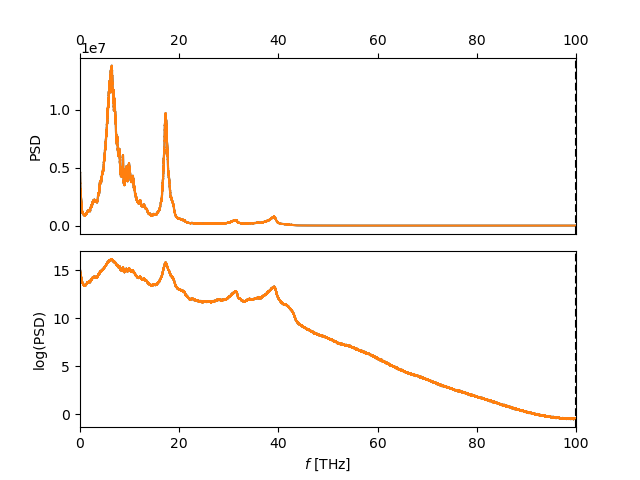

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     100.00000 THz
 Resampling freq          f* =     100.00000 THz
 Sampling time         TSKIP =             1 steps
                             =         5.000 fs
 Original  n. of frequencies =       1000001
 Resampled n. of frequencies =       1000001
 PSD      @cutoff  (pre-filter) =      0.80374
                  (post-filter) =      0.80374
 log(PSD) @cutoff  (pre-filter) =     -0.41555
                  (post-filter) =     -0.41555
 min(PSD)          (pre-filter) =      0.00103
 min(PSD)         (post-filter) =      0.00103
 % of original PSD Power f<f* (pre-filter)  = 100.000000
-----------------------------------------------------



In [29]:
jf=j.resample_current(PSD_FILTER_W=0.1, fstar_THz=100)

In [21]:
j.mel_cepstral_analysis()

-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 373  (P* = 374, corr_factor = 1.000000)
  L_0*   =          14.866124 +/-   0.021949
  S_0*   =     5092808.630634 +/- 111782.885780
-----------------------------------------------------
  Mel kappa* =           9.273735 +/-   0.203551  W/mK
-----------------------------------------------------



In [20]:
j.compute_mel_filter(triang=True)

bins=[0.00000e+00 4.60000e+01 9.20000e+01 ... 9.90730e+05 9.95355e+05
 1.00000e+06]
out=[8.14462699e+05 5.30751387e+06 5.36490266e+06 ... 7.87506056e-01
 7.88306785e-01 8.98948830e-02]


In [18]:
# jr=j.resample_current(fstar_THz=1.0)[0]
j.cepstral_analysis()

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 380  (P* = 381, corr_factor = 1.000000)
  L_0*   =          14.615984 +/-   0.022154
  S_0*   =     3965726.541905 +/- 87856.268035
-----------------------------------------------------
  kappa* =           7.221378 +/-   0.159982  W/mK
-----------------------------------------------------



In [43]:
j10k.mel_cepstral_analysis()

-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 557  (P* = 558, corr_factor = 1.000000)
  L_0*   =          14.943622 +/-   0.026816
  S_0*   =     5503186.860271 +/- 147573.831169
-----------------------------------------------------
  Mel kappa* =          10.021012 +/-   0.268724  W/mK
-----------------------------------------------------



In [47]:
j50k.mel_cepstral_analysis()

-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 349  (P* = 350, corr_factor = 1.000000)
  L_0*   =          14.731598 +/-   0.021232
  S_0*   =     4451777.790505 +/- 94521.308544
-----------------------------------------------------
  Mel kappa* =           8.106452 +/-   0.172118  W/mK
-----------------------------------------------------



In [6]:
jpsd_sq = np.copy(j.mel_dct.psd)

<IPython.core.display.Javascript object>


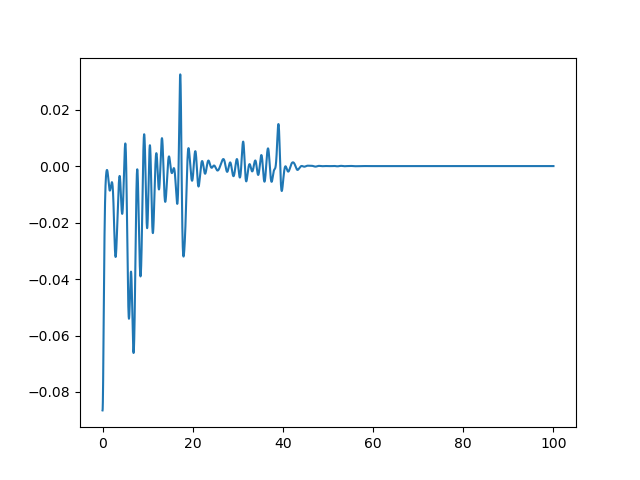

In [14]:
%matplotlib notebook
plt.plot(j.mel_filtered_freqs_THz*1e-24, conv*(j.mel_dct.psd-jpsd_sq), label='tr')


In [ ]:
j.mel_cepstral_analysis()

<IPython.core.display.Javascript object>


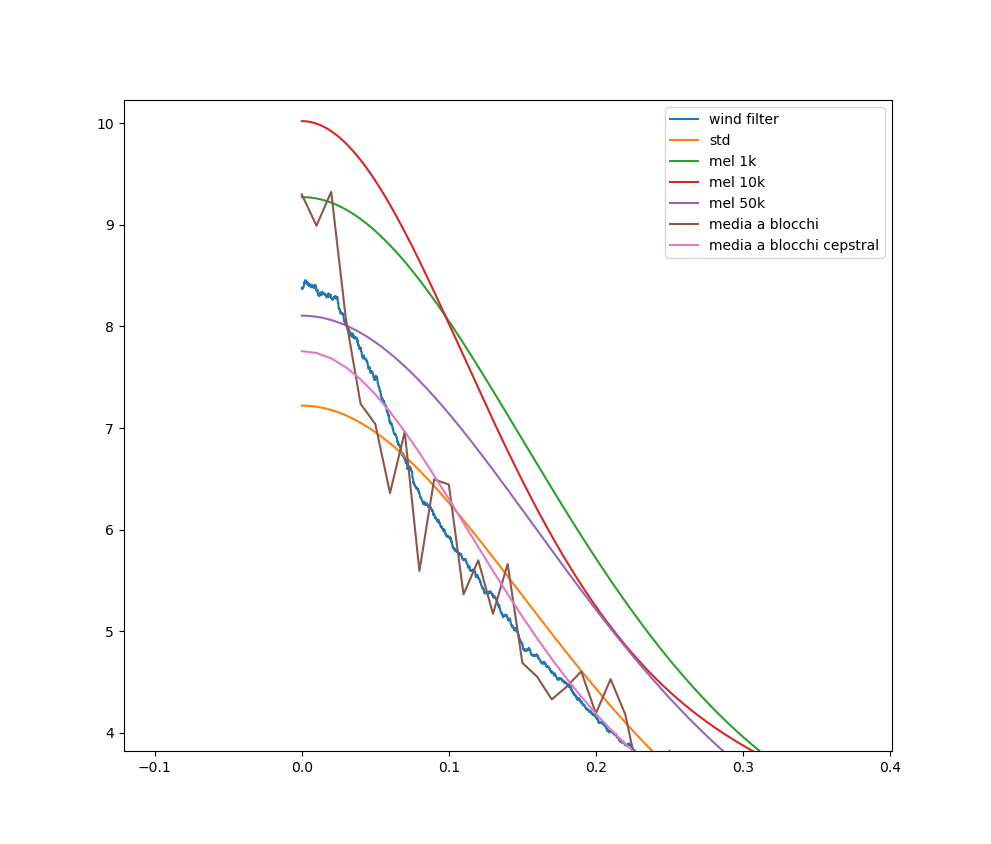

In [48]:
%matplotlib notebook
conv=j.kappa_scale/2
# plt.plot(j.freqs_THz, j.psd*conv, label='no filter', alpha=0.5)
plt.plot(jf[0].freqs_THz, jf[0].fpsd*conv, label='wind filter')

plt.plot(j.freqs_THz, j.dct.psd*conv, label='std')
plt.plot(j.mel_filtered_freqs_THz*1e-24, conv*j.mel_dct.psd, label='mel 1k')
plt.plot(j.mel_filtered_freqs_THz*1e-24, conv*j10k.mel_dct.psd, label='mel 10k')
plt.plot(j.mel_filtered_freqs_THz*1e-24, conv*j50k.mel_dct.psd, label='mel 50k')


# plt.plot(j.mel_filtered_freqs_THz*1e-24, conv*jpsd_sq, label='sq')

plt.plot(jnewfull.freqs_THz,jnewfull.psd*conv, label='media a blocchi') #,marker=marker,ms=ms,lw=lw)
plt.plot(jnewfull.freqs_THz,jnewfull.dct.psd*conv, label='media a blocchi cepstral') #,marker=marker,ms=ms,lw=lw)


plt.legend()

In [33]:
jene=d['flux']
jele=d['jel']
N=len(jene)
print('{} ps'.format(N*0.005))
n=100
print('{} subtrajs. of {} ps'.format(n, N//n*0.005))

bau=np.array([jc.reshape(n, N//n).T for jc in jene.T])
newjene=np.concatenate(bau.T, axis=1)

bau=np.array([jc.reshape(n, N//n).T for jc in jele.T])
newjele=np.concatenate(bau.T, axis=1)

10000.0 ps
100 subtrajs. of 100.0 ps


In [36]:
%matplotlib notebook

fstar=3.0
FILT=0.1

jnew = tc.HeatCurrent(j=[newjene, newjele], DT_FS=5.0, TEMPERATURE=np.mean(d['Temp']), units='metal', VOLUME=vol)
jnewfull = jnew.resample_current(fstar_THz=100, PSD_FILTER_W=FILT, plot=False)
jnewfull.compute_psd()
jnewfull.cepstral_analysis()
jnewfstar = jnew.resample_current(fstar_THz=fstar, PSD_FILTER_W=FILT, plot=False)
jnewfstar.compute_psd()
jnewfstar.cepstral_analysis()
conv=jnewfstar.kappa_scale/2

marker='o'
ms=2
lw=0.5

Using multicomponent code.
Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     100.00000 THz
 Resampling freq          f* =     100.00000 THz
 Sampling time         TSKIP =             1 steps
                             =         5.000 fs
 Original  n. of frequencies =         10001
 Resampled n. of frequencies =         10001
 fPSD not calculated before resampling!
 -----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 556  (P* = 557, corr_factor = 1.000000)
  L_0*   =          15.261427 +/-   0.019310
  S_0*   =     4259978.853891 +/- 82258.853977
-----------------------------------------------------
  kappa* =           7.757196 +/-   0.149789  W/mK
-----------------------------------------------------

In [ ]:
jnewfull.